<a href="https://colab.research.google.com/github/sebaszx/IamgeSegmentation/blob/main/Image_Segmentation_(_Cells)_Using_Keras_and_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cosas que recordar

U-Net es una FCNN lo que quiere decir que que no utiliza dense layers para clasificar si no que usa capas convoluciones de filtros de 1x1 con stride 1 

En la ultima capa es donde se especifican los clases que queremos clasificar en este caso ponemos 1 capa y como es solo una podemos usar la función sigmoid. Si necesitaramos más clases ( nuestro groundtruth tiene más de un color ) entonces usamos la función softmax y la cantidad de filtros de la ultima capa, vienen siendo la cantidad de clases



In [ ]:
#define U-net Arquitecture
import numpy as np
from keras.models import Sequential,Model
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Lambda,Conv2DTranspose,concatenate,Input,Lambda
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from keras.utils import np_utils
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  confusion_matrix,ConfusionMatrixDisplay
import os# this could be Drive 
from tqdm import tqdm 
import random 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
#from mlxtend.plotting import plot_decision_regions

In [ ]:
IMAGE_HEIGHT=128
IMAGE_WIDTH=128
IMG_CHANNELS=3
TRAIN_PATH="./stage1_train/"
TEST_PATH="./stage1_test/"
latest_file=""

Utilizando el modelo API funcional de KERAS


In [ ]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = Conv2D(n_filters, (3, 3), padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x= Dropout(.3)(x)
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, (3, 3), padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = MaxPooling2D(2)(f)
   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = Conv2DTranspose(n_filters, (2,2), strides=(2,2), padding="same")(x)
   # concatenate
   x = concatenate([x, conv_features])
   # dropout
   x = Dropout(0.2)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [ ]:
def Unet():
  # inputs
  inputs = Input(shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))
  s = Lambda(lambda x: x / 255)(inputs)
  # encoder: contracting path - downsample
  # 1 - downsample
  f1, p1 = downsample_block(s, 16)
  # 2 - downsample
  f2, p2 = downsample_block(p1, 32)
  # 3 - downsample
  f3, p3 = downsample_block(p2, 64)
  # 4 - downsample
  f4, p4 = downsample_block(p3, 128)
    # 5 - bottleneck
  bottleneck = double_conv_block(p4, 256)
    # decoder: expanding path - upsample
    # 6 - upsample
  u6 = upsample_block(bottleneck, f4, 128)
    # 7 - upsample
  u7 = upsample_block(u6, f3, 64)
    # 8 - upsample
  u8 = upsample_block(u7, f2, 32)
    # 9 - upsample
  u9 = upsample_block(u8, f1, 16)

  # outputs
  outputs = Conv2D(1, (1,1), padding="same", activation = "sigmoid")(u9)
# unet model with Keras Functional API
  unet_model = Model(inputs, outputs, name="U-Net")
  return unet_model

In [ ]:
model=Unet()


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
#callbacks

my_callbacks = [
    EarlyStopping(patience=2),
    ModelCheckpoint(filepath='Checkpoints/ImageSegmentation.{epoch:02d}-{val_loss:.2f}.h5',verbose=1,save_best_only=True),
   TensorBoard(log_dir='./logs'),
]

In [ ]:
def read_data(Train,Test):
    train_ids = next(os.walk(TRAIN_PATH))[1]
    test_ids = next(os.walk(TEST_PATH))[1]

    X_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)

    print('Resizing training images and masks')
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
        img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img  #Fill empty X_train with values from img
        mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant',  
                                          preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)  

        Y_train[n] = mask   

    # test images
    X_test = np.zeros((len(test_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('Resizing test images') 
    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img

    print('Done!')
   





    return X_train,Y_train,X_test
  

Get the lastest .h5 file if exists to pretrain the model 

In [ ]:
import glob
import os

list_of_files = glob.glob('./*.h5') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
if latest_file != '':
    print(latest_file)
    model.load_weights(latest_file)
    weights = model.get_weights()
    print(weights)

In [ ]:
from sklearn.model_selection import train_test_split
X,y,test= read_data(TRAIN_PATH,TEST_PATH)



<ipython-input-10-d8aa3fc6ddba>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
  0%|          | 0/670 [00:00<?, ?it/s]

Resizing training images and masks


<ipython-input-10-d8aa3fc6ddba>:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
  9%|▉         | 6/65 [00:00<00:01, 53.10it/s]

Resizing test images


100%|██████████| 65/65 [00:01<00:00, 41.64it/s]

Done!


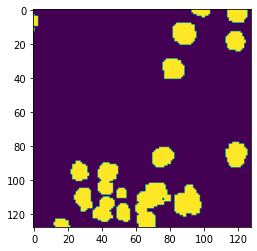

In [ ]:
plt.imshow(y[0])
plt.show()

In [ ]:

if latest_file=="":
    print("Checkpoint not found")
    history=model.fit(X, y, validation_split=0.1, batch_size=16, epochs=25)
    
else:
    print("Found Checkpoint")
    score=model.evaluate(X,y)
    print(score)

Found Checkpoint
21/21 [==============================] - 13s 584ms/step - loss: 0.0815 - accuracy: 0.9686
[0.08149908483028412, 0.9685640931129456]


3/3 [==============================] - 1s 303ms/step


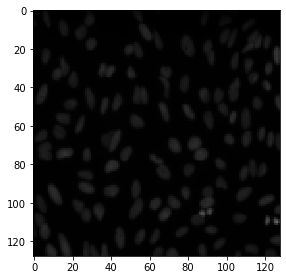

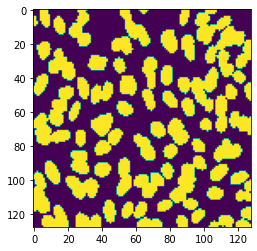

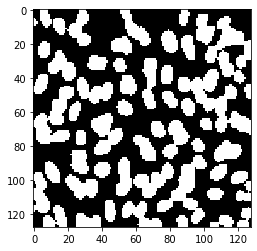

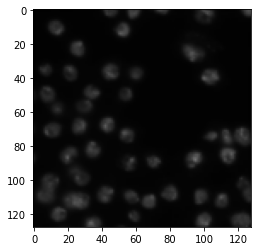

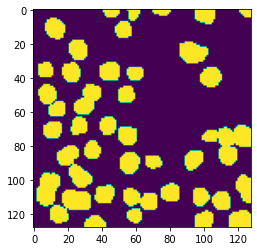

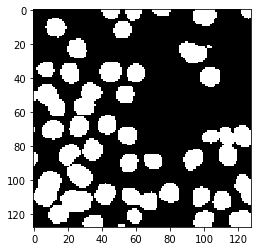

In [ ]:

idx = random.randint(0, len(X))


preds_train = model.predict(X[:int(X.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X[int(X.shape[0]*0.9):], verbose=1)
preds_test = model.predict(test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X[ix])
plt.show()
plt.imshow(np.squeeze(y[ix]))
plt.show()
plt.imshow(np.squeeze(preds_train_t[ix]),cmap=plt.cm.gray, interpolation='nearest') 
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
plt.imshow(X[int(X.shape[0]*0.9):][ix])
plt.show()
plt.imshow(np.squeeze(y[int(y.shape[0]*0.9):][ix]))
plt.show()
plt.imshow(np.squeeze(preds_val_t[ix]),cmap=plt.cm.gray, interpolation='nearest')
plt.show()


In [ ]:
print(X_trains.shape)
#print(X_train[1])
print(X_trains[:int(X_trains.shape[0]*0.9)].shape)
print(X_trains[int(X_trains.shape[0]*0.9):].shape)

NameError: name 'X_trains' is not defined

In [ ]:
y_trains[ix]

In [ ]:
preds_train[ix]

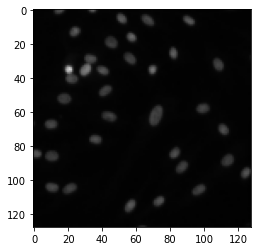

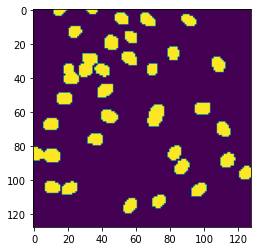

(128, 128, 3)
1/1 [==============================] - 0s 48ms/step
[[[0.15511224]
  [0.03651861]
  [0.02232311]
  ...
  [0.0114589 ]
  [0.03026436]
  [0.09093776]]

 [[0.04031488]
  [0.00496769]
  [0.00171469]
  ...
  [0.00075368]
  [0.00336435]
  [0.02509622]]

 [[0.01842015]
  [0.00185086]
  [0.00057108]
  ...
  [0.00022088]
  [0.00101062]
  [0.01400624]]

 ...

 [[0.01307072]
  [0.00127048]
  [0.00035743]
  ...
  [0.00019425]
  [0.00089957]
  [0.00837927]]

 [[0.02249007]
  [0.00326772]
  [0.0014482 ]
  ...
  [0.00080104]
  [0.00272068]
  [0.02808035]]

 [[0.08293395]
  [0.02530253]
  [0.01548588]
  ...
  [0.00977105]
  [0.02485487]
  [0.10201633]]] hola


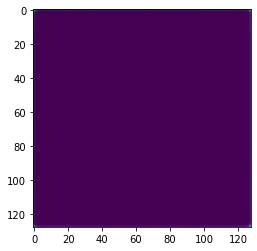

In [ ]:
plt.imshow(X[1])
plt.show()
plt.imshow(y[1])
plt.show()
print(X[1].shape)
y_pred=model.predict(X[:2]/255)
print(y_pred[0],"hola")
plt.imshow(y_pred[1])
plt.show()